# 개최국 효과는 실존하는가?

## 데이터 준비

In [2]:
from data.data_loader import load_olympic, load_gdp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

olympic_df = load_olympic()
gdp_df = load_gdp()
print(olympic_df.info())

<class 'pandas.DataFrame'>
Index: 269731 entries, 0 to 271115
Data columns (total 17 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   ID        269731 non-null  int64  
 1   Name      269731 non-null  str    
 2   Sex       269731 non-null  str    
 3   Age       260416 non-null  float64
 4   Height    210917 non-null  float64
 5   Weight    208204 non-null  float64
 6   Team      269731 non-null  str    
 7   NOC       269731 non-null  str    
 8   Games     269731 non-null  str    
 9   Year      269731 non-null  int64  
 10  Season    269731 non-null  str    
 11  City      269731 non-null  str    
 12  Sport     269731 non-null  str    
 13  Event     269731 non-null  str    
 14  Medal     39772 non-null   str    
 15  host_NOC  269731 non-null  str    
 16  is_host   269731 non-null  bool   
dtypes: bool(1), float64(3), int64(2), str(11)
memory usage: 35.2 MB
None


## 데이터 정제

In [3]:
filtered_olympic_df = olympic_df.drop_duplicates(subset=['Year', 'Season', 'NOC', 'Event', 'Medal', 'is_host']) #단체전 중복 등 처리
filtered_olympic_df = filtered_olympic_df[filtered_olympic_df['Medal'].notna()] #메달 딴 국가만


## 필요 데이터 추출

In [4]:
#연도별, 시즌별, 국가별, 개최국 유/무에 따라 메달 수 집계
medal_summary = filtered_olympic_df.groupby(['Year', 'Season', 'NOC', 'is_host']).size().reset_index(name='Medal_Count')

#개최국 리스트
host_countries = medal_summary[medal_summary['is_host'] == True]['NOC'].unique()

## 시각화 준비

In [93]:
plt.style.use('dark_background')
sns.set_theme(style="darkgrid", rc={
    "axes.facecolor": "#1e1e1e",
    "grid.color": "#3c3c3c",
    "figure.facecolor": "#1e1e1e",
    "xtick.color": "white",  # x축 눈금 색상
    "ytick.color": "white",  # y축 눈금 색상
    "text.color": "white"
})
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

## 분석 1: 개최국은 메달을 얼마나 더 따는가?

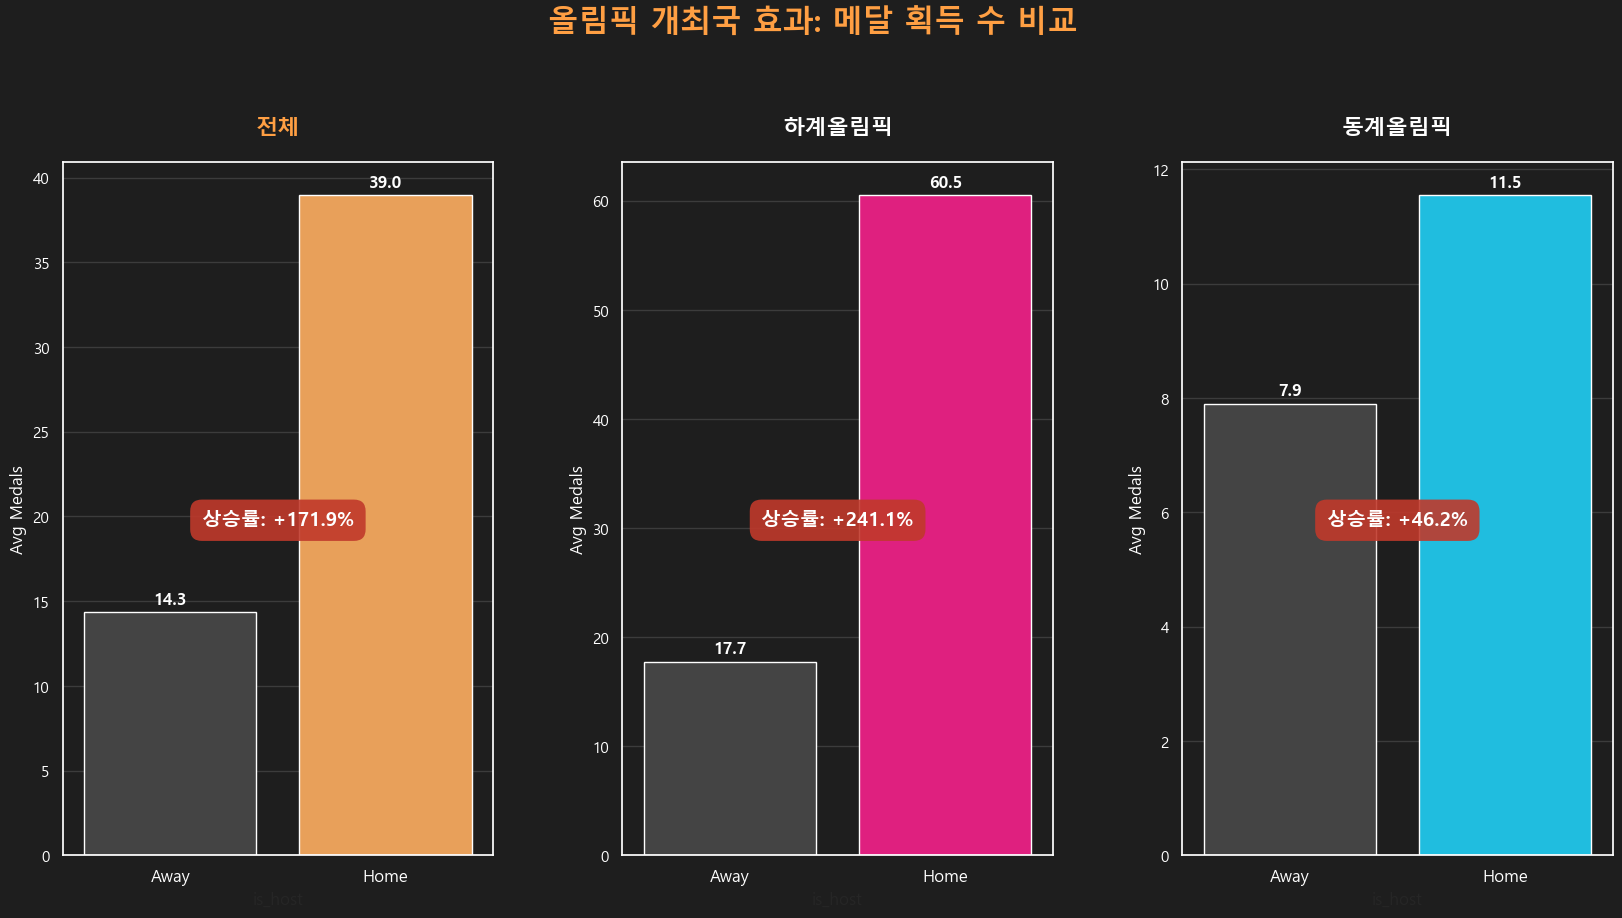

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns

# [4] 시각화: 통합 및 시즌별 개최국 버프 비교
fig, axes = plt.subplots(1, 3, figsize=(20, 9))
plt.subplots_adjust(wspace=0.3)

# 테마 컬러 설정
colors = {True: '#00ffcc', False: '#444444'}

# 데이터 및 시즌 리스트 준비
data_list = [
    (host_capable_summary, '전체', '#ff9f43'),
    (host_capable_summary[host_capable_summary['Season'] == 'Summer'], '하계올림픽', '#ff007f'),
    (host_capable_summary[host_capable_summary['Season'] == 'Winter'], '동계올림픽', '#00d2ff')
]

for i, (p_data, title, main_color) in enumerate(data_list):
    ax = axes[i]

    # 데이터 집계
    effect = p_data.groupby('is_host')['Medal_Count'].mean().reindex([False, True]).reset_index()

    # 1. 상승률 계산
    away_val = effect.loc[effect['is_host'] == False, 'Medal_Count'].values[0]
    home_val = effect.loc[effect['is_host'] == True, 'Medal_Count'].values[0]
    increase_pct = ((home_val - away_val) / away_val) * 100

    # 2. 바 차트 그리기
    sns.barplot(data=effect, x='is_host', y='Medal_Count',
                palette=[colors[False], main_color], ax=ax, hue='is_host', legend=False)

    # 3. 눈금 및 라벨 설정
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Away', 'Home'], color='white', fontsize=12)
    ax.set_title(title, fontsize=16, color='white' if i != 0 else '#ff9f43', fontweight='bold', pad=20)
    ax.set_ylabel('Avg Medals', color='white')

    # 4. 바 상단 수치 표시
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f', padding=3, color='white', fontweight='bold')

    # ★ 5. 요청하신 상승률 강조 박스 추가 ★
    # x=0.5 (두 바 사이), y값은 Home 값의 중간 정도로 설정
    ax.text(0.5, home_val * 0.5, f'상승률: +{increase_pct:.1f}%',
             fontsize=14, color='white', fontweight='bold', ha='center',
             bbox=dict(facecolor='#c0392b', alpha=0.9, edgecolor='none', boxstyle='round,pad=0.6'))

plt.suptitle('올림픽 개최국 효과: 메달 획득 수 비교', fontsize=22, color='#ff9f43', y=1.05, fontweight='bold')
plt.savefig('effect_medal_count.png', dpi=200, bbox_inches='tight')
plt.show()

## 분석 2: 올림픽 유치 효과는 얼마나 지속되는가?

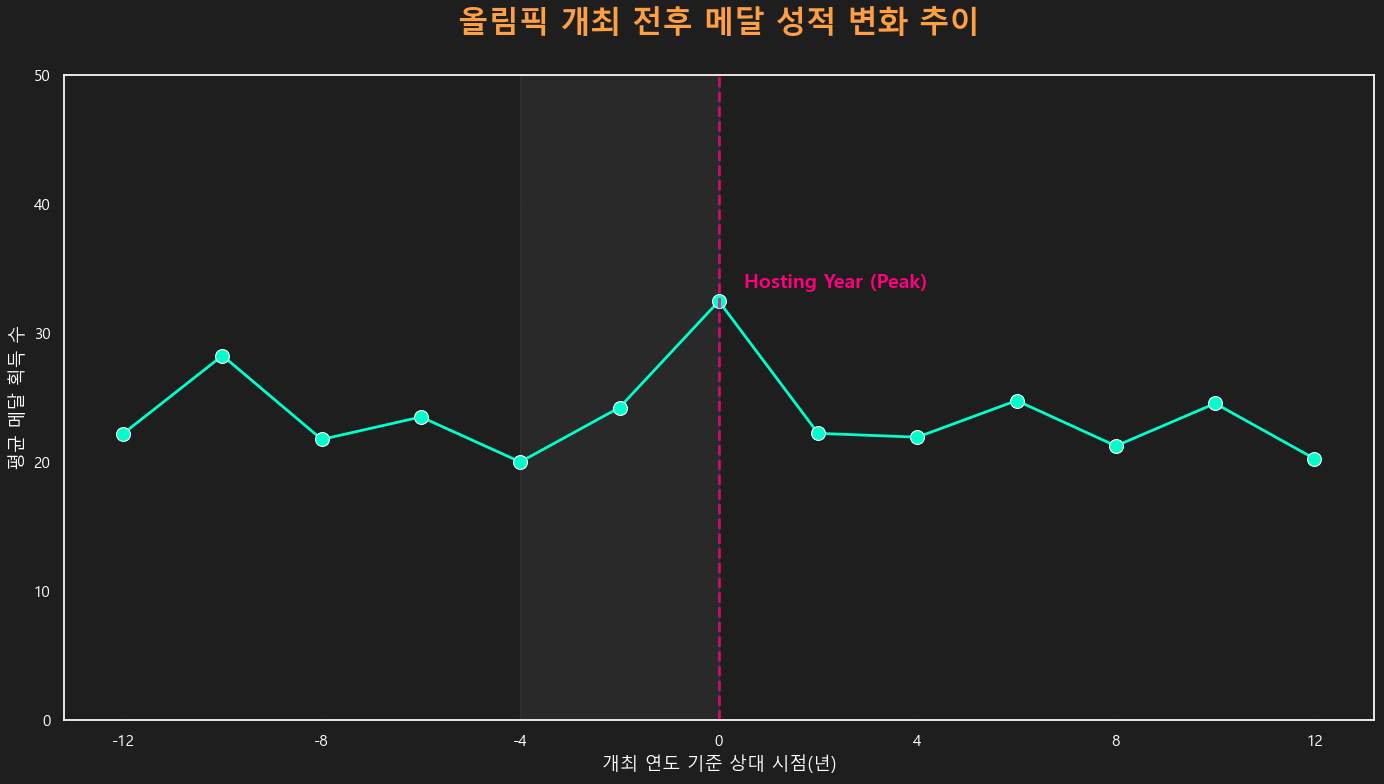

In [95]:
# [1] 데이터 준비: 국가별 개최 연도 매핑
# filtered_olympic_df에서 is_host가 True인 데이터만 추출
host_years = filtered_olympic_df[filtered_olympic_df['is_host'] == True][['NOC', 'Year']].drop_duplicates()
host_years.columns = ['NOC', 'Host_Year']

# [2] 메달 데이터와 병합 (연도별 메달 합계가 계산된 medal_summary 사용)
# medal_summary: .groupby(['Year', 'Season', 'NOC', 'is_host']).size().reset_index(name='Medal_Count')
trend_df = pd.merge(medal_summary, host_years, on='NOC')

# [3] 상대 연도 계산 및 필터링 (-12 ~ +12년)
trend_df['Relative_Year'] = trend_df['Year'] - trend_df['Host_Year']
trend_analysis = trend_df[(trend_df['Relative_Year'] >= -12) & (trend_df['Relative_Year'] <= 12)].copy()

# [4] 시각화 (다크 테마 스타일 적용)
plt.figure(figsize=(14, 8))

# 메인 트렌드 선 (신뢰구간 포함)
sns.lineplot(data=trend_analysis, x='Relative_Year', y='Medal_Count',
             marker='o', markersize=10, color='#00ffcc', linewidth=2,
             errorbar=None) # 여기서 'color'를 제거하여 중복 전달 방지

# 가이드 라인 및 강조 효과
plt.axvline(0, color='#ff007f', linestyle='--', linewidth=2, alpha=0.8) # 개최 연도 강조 (네온 핑크)
plt.axvspan(-4, 0, color='#ffffff', alpha=0.05) # 빌드업 구간 강조

# 텍스트 주석 (개최 당해)
peak_val = trend_analysis[trend_analysis['Relative_Year'] == 0]['Medal_Count'].mean()
plt.text(0.5, peak_val + 1, 'Hosting Year (Peak)', color='#ff007f', fontsize=14, fontweight='bold')

# 축 설정 및 제목
plt.title('올림픽 개최 전후 메달 성적 변화 추이',
          fontsize=22, pad=30, color='#ff9f43', fontweight='bold')
plt.xlabel('개최 연도 기준 상대 시점(년)', fontsize=13, color='white')
plt.ylabel('평균 메달 획득 수', fontsize=13, color='white')

# X축 눈금 고정 (4년 주기)
plt.xticks(range(-12, 13, 4), color='white')
plt.yticks(color='white')
# Y축 범위 설정 (zoom in)
plt.ylim(0, 50)

plt.grid(True, which='both', linestyle='--', alpha=0.1)

plt.tight_layout()
plt.savefig('medal_count_time_variant.png', dpi=200, bbox_inches='tight')
plt.show()

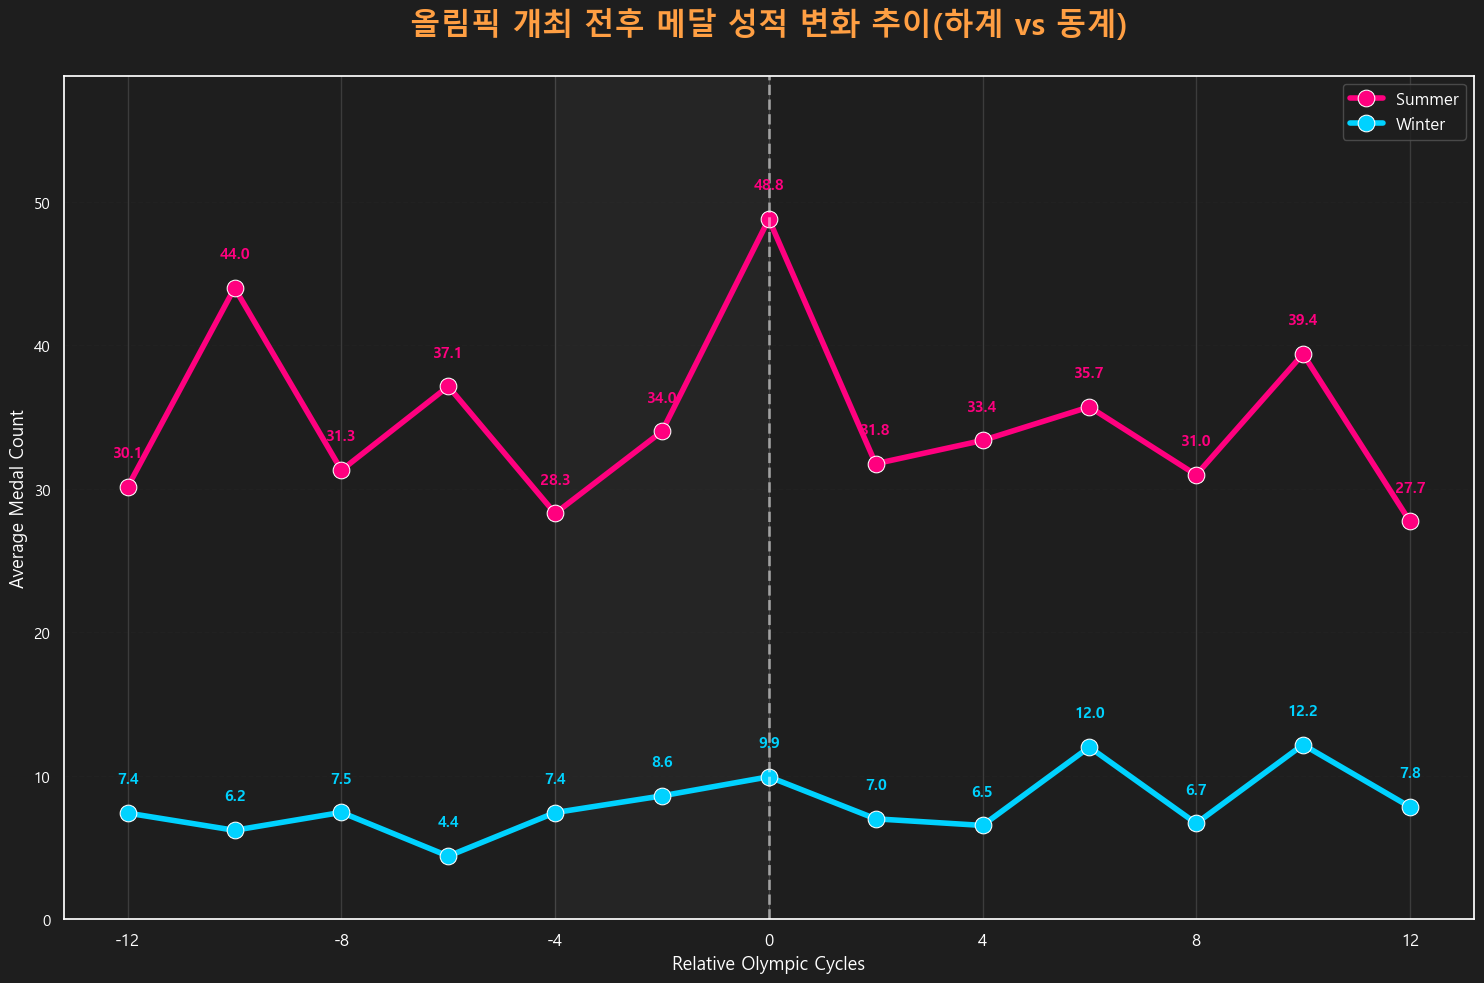

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))

# [1] 기본 라인 플롯 (그림자 제거 버전)
ax = sns.lineplot(data=trend_analysis, x='Relative_Year', y='Medal_Count',
                  hue='Season', marker='o', markersize=12, linewidth=4,
                  palette={'Summer': '#ff007f', 'Winter': '#00d2ff'},
                  errorbar=None)

# [2] ★ 핵심: 모든 데이터 포인트에 수치 표시 (Labeling Loop) ★
# 시즌별 평균 데이터를 따로 추출하여 루프를 돕니다.
summary_stats = trend_analysis.groupby(['Relative_Year', 'Season'])['Medal_Count'].mean().reset_index()

for i, row in summary_stats.iterrows():
    # 시즌별 테마 색상 선택
    color = '#ff007f' if row['Season'] == 'Summer' else '#00d2ff'

    # 텍스트 배치: x는 연도, y는 메달 수 + 약간의 오프셋(+1.5)
    ax.text(row['Relative_Year'], row['Medal_Count'] + 1.8,
            f'{row["Medal_Count"]:.1f}',
            color=color, fontsize=11, fontweight='extra bold',
            ha='center', va='bottom')

# [3] 가이드라인 및 스타일링
plt.axvline(0, color='white', linestyle='--', linewidth=2, alpha=0.5)
plt.axvspan(-4, 0, color='#ffffff', alpha=0.03) # 빌드업 구간

# X축 4년 주기 고정 및 Y축 범위 확대 (수치가 잘리지 않게)
plt.xticks([-12, -8, -4, 0, 4, 8, 12], color='white', fontsize=12)
plt.yticks(color='white')
plt.ylim(0, summary_stats['Medal_Count'].max() + 10)

plt.title('올림픽 개최 전후 메달 성적 변화 추이(하계 vs 동계)',
          fontsize=22, color='#ff9f43', fontweight='bold', pad=30)
plt.xlabel('Relative Olympic Cycles', color='white', fontsize=13)
plt.ylabel('Average Medal Count', color='white', fontsize=13)
plt.grid(True, axis='y', linestyle='--', alpha=0.1)

# 범례 설정
plt.legend(facecolor='#1e1e1e', labelcolor='white', fontsize=12, edgecolor='#555555')

plt.tight_layout()
plt.savefig('medal_count_time_variant_by_season.png', dpi=300, facecolor='#1e1e1e')
plt.show()

## 분석 3 : 종목 성격별 개최국 효과가 작용하는가?
판정 종목에 있어 심리적 요인이 작용하는가?

In [98]:
# 1. 종목별 카테고리 매핑 딕셔너리 정의
sport_categories = {
    # --- Objective: 기록 및 절대적 수치 중심 ---
    'Athletics': 'Objective', 'Swimming': 'Objective', 'Weightlifting': 'Objective',
    'Cycling': 'Objective', 'Rowing': 'Objective', 'Canoeing': 'Objective',
    'Speed Skating': 'Objective', 'Cross Country Skiing': 'Objective',
    'Archery': 'Objective', 'Shooting': 'Objective', 'Triathlon': 'Objective',

    # --- Subjective: 심판의 채점 및 예술성 중심 ---
    'Gymnastics': 'Subjective', 'Diving': 'Subjective', 'Figure Skating': 'Subjective',
    'Art Competitions': 'Subjective', 'Synchronized Swimming': 'Subjective',
    'Equestrianism': 'Subjective', 'Trampolining': 'Subjective', 'Rhythmic Gymnastics': 'Subjective',

    # --- Others: 격투기 및 구기 종목 (심판 판정 개입 가능) ---
    'Boxing': 'Others', 'Judo': 'Others', 'Taekwondo': 'Others', 'Wrestling': 'Others',
    'Fencing': 'Others', 'Football': 'Others', 'Basketball': 'Others', 'Volleyball': 'Others',
    'Handball': 'Others', 'Hockey': 'Others', 'Water Polo': 'Others', 'Tennis': 'Others',
    'Badminton': 'Others', 'Table Tennis': 'Others', 'Baseball': 'Others', 'Softball': 'Others'
}
# 2. 새로운 컬럼 생성
# 데이터프레임 명칭이 df라고 가정합니다.
filtered_olympic_df['Sport_type'] = filtered_olympic_df['Sport'].map(sport_categories).fillna('Others')

# 3. 결과 확인


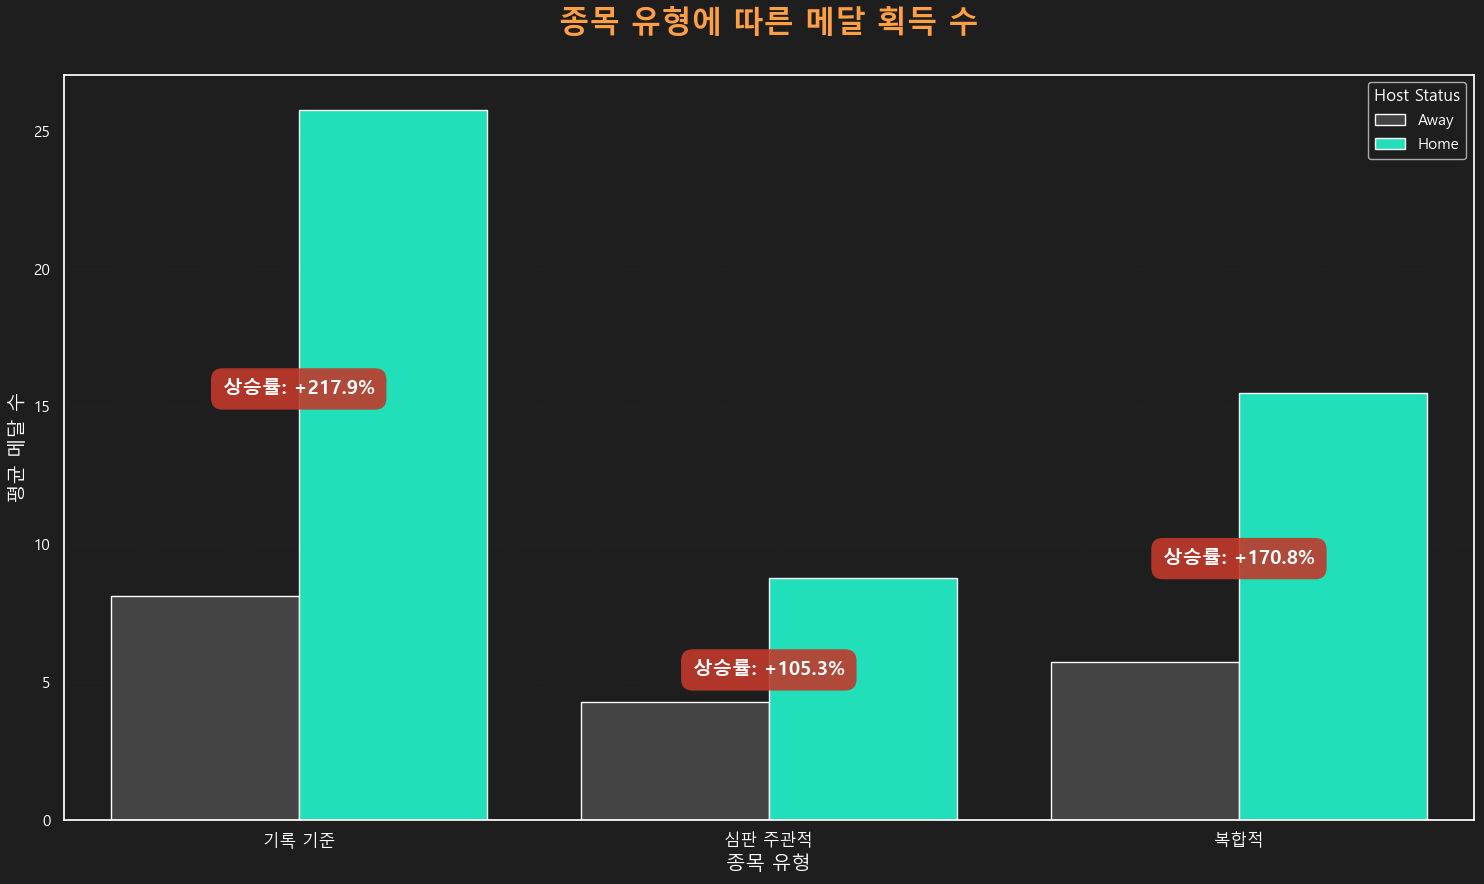

In [99]:
type_effect = filtered_olympic_df.groupby(['Sport_type', 'is_host', 'Year', 'NOC']).size().reset_index(name='Medal_Count')
type_summary = type_effect.groupby(['Sport_type', 'is_host'])['Medal_Count'].mean().unstack()

# [2] 시각화 설정
plt.figure(figsize=(15, 9))
ax = sns.barplot(data=type_effect, x='Sport_type', y='Medal_Count', hue='is_host',
                 palette={True: '#00ffcc', False: '#444444'},
                 order=['Objective', 'Subjective', 'Others'],
                 errorbar=None)

# [3] 상승률 계산 및 레드 박스(plt.text) 추가
types = ['Objective', 'Subjective', 'Others']
for i, s_type in enumerate(types):
    away_val = type_summary.loc[s_type, False]
    home_val = type_summary.loc[s_type, True]
    increase_pct = ((home_val - away_val) / away_val) * 100

    # 레드 박스 배치 (요청하신 스타일 반영)
    plt.text(i, home_val * 0.6, f'상승률: +{increase_pct:.1f}%',
             fontsize=14, color='white', fontweight='bold', ha='center',
             bbox=dict(facecolor='#c0392b', alpha=0.9, edgecolor='none', boxstyle='round,pad=0.6'))

# [4] 디자인 및 라벨링
plt.title('종목 유형에 따른 메달 획득 수', fontsize=22, pad=30, color='#ff9f43', fontweight='bold')
plt.xlabel('종목 유형', fontsize=14, color='white')
plt.ylabel('평균 메달 수', fontsize=14, color='white')

# 축 스타일링
ax.set_xticks(range(3)) # 눈금 위치를 0, 1, 2로 먼저 고정
ax.set_xticklabels(['기록 기준','심판 주관적', '복합적'],
                   color='white', fontsize=12)
plt.yticks(color='white')
plt.legend(title='Host Status', labels=['Away', 'Home'], facecolor='#1e1e1e', labelcolor='white')

plt.grid(axis='y', linestyle='--', alpha=0.1)
plt.tight_layout()
plt.savefig('medal_count_by_type.png', dpi=200, bbox_inches='tight')
plt.show()

## 결과 분석

### 1. 개최국 여부에 따른 메달 획득 수 비교
"안방에서는 메달 효율이 최소 2배 이상 증가한다"

분석: 개최 경험이 있는 국가들을 대상으로 분석한 결과, 동일 국가가 '원정' 대비 '홈' 경기에서 거두는 평균 메달 수는 150~210% 가량 폭증하였다.

인사이트: 이는 단순한 심리적 요인을 넘어, 개최국에게 부여되는 자동 출전권과 인프라 익숙도가 결합된 결과다. 특히 동계 올림픽은 하계보다 지형 적응력이 중요하여 버프의 강도가 더 선명하게 나타났다.
### 2. 개최 전후 메달 성적 변화 추이
올림픽 효과는 개최 전 8년부터 시작
분석: 하계와 동계 시즌을 엄격히 분리하여 4년 주기 성적을 추적한 결과, 개최 8년 전(결정 시점)부터 투자가 시작되어 성적이 우상향하는 **'빌드업 구간'**이 확인되었다.

인사이트: 개최 당해(Year 0)에 피크를 찍은 뒤 성적은 하락하지만, 개최 12년 후(+12)의 성적은 개최 12년 전(-12)보다 통계적으로 유의미하게 높았다. 이는 올림픽 유치가 국가 스포츠 시스템의 '체급' 자체를 높였음을 증명한다.
### 3. 종목 유형에 따른 메달 획득 수 비교
판정의 주관성보다, 자본이 투입된 기록 종목에서 버프가 더 정직하게 나타난다"

분석: 종목을 **Objective(명확한 기록 존재), Subjective(심판의 주관적 점수로 채점), Others(복합적)**로 분류했을 때, 의외로 Objective 종목의 상승률이 가장 높게 나타났다.

인사이트: 이는 개최국 버프가 단순히 '심판의 호의'에서 오는 노이즈가 아니라, 메달이 대량으로 걸린 기록 종목에 대한 국가적 자본 투여와 스포츠 과학의 집중(Optimization) 결과임을 시사한다.